# Import libraries

In [47]:
import pandas as pd
from pylab import *
import seaborn as sns
sns.set(style="whitegrid")
import csv
import gc
import scipy
from scipy.stats.stats import pearsonr, spearmanr
import time
from tqdm import *
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

pd.set_option('display.max_columns', None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'random', 'info', 'power', 'linalg', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Define import and export paths

In [63]:
import_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Input/'
export_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Output/'
path_fig = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Output/Figures/'

# Define variables to test

In [49]:
variables_to_test = (['Domain',
                     'filing_year',
                     'CITE3',
                     'CITE3_RANK_PERC_BY_YEAR',
                     'CITE3_RANK_PERC_BY_YEAR_AND_CLASS',
                     'mean_age_cited_patents',
                     'mean_age_cited_patents_RANK_PERC_BY_YEAR',
                     'count_citations_made',
                     'log_count_citations_made',
                     'within_USPCclass_citation_share',
                     'within_IPCclass_citation_share',
                     'within_domain_citation_share',
                     'SPNP_count_t3_RankPerc_by_year',
                     'SPNP_count_t3_randomized_percentile',
                     'SPNP_count_t3_randomized_zscore_RPbyYear',
                     'meanSPNPcited_1year_before_RankPerc_by_year',
                     'meanSPNPcited_1year_before_randomized_percentile',
                     'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'])

# Import and Manipulate Data

In [50]:
ti = time.time()
# Read file with list of patents for each domain
PATENT_SET_DOMAINS = pd.read_csv(import_path+'Domains_patent_info.csv',usecols=variables_to_test+['patent_number'])
tf = time.time()
(tf-ti)/60

0.03362665971120198

In [51]:
# Read file with information on all utility patents granted by the USPTO between 1975 and 2015
PATENT_INFO = pd.read_csv(import_path+'All_patents_info.csv')
PATENT_INFO.drop_duplicates('patent_number', keep = 'first', inplace=True)
idx_letters = PATENT_INFO['mainclass_id'].astype(str).str.contains('a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|/|;|-|nan', na=False, case=False)
PATENT_INFO['mainclass_id'][~idx_letters] = PATENT_INFO['mainclass_id'][~idx_letters].astype(int).astype(str)
PATENT_INFO['mainclass_id'] = PATENT_INFO['mainclass_id'].astype(str)
PATENT_INFO['grant_year'] = PATENT_INFO['grant_date'].astype(str).apply(lambda x: x[:4])
tf = time.time()
(tf-ti)/60

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.8152684013048808

In [55]:
# Read file with list TIRs for each domain
PERFORMANCE_DOMAINS = pd.read_csv(import_path+'PERFORMANCE_DOMAINS_K_Kr2.csv')
PERFORMANCE_DOMAINS['log_K'] = log(PERFORMANCE_DOMAINS['K'])

In [56]:
# Create dataframe with patent count and mean variables per domain over time
PERFORMANCE_DOMAINS = PERFORMANCE_DOMAINS.sort_values('Domain')
DF_domains_over_time = pd.DataFrame()
for year in tqdm(range(1980,2014)):
    DATA = PATENT_SET_DOMAINS[PATENT_SET_DOMAINS['filing_year']<=year]

    SIZE_DOMAIN = DATA[['Domain','patent_number']].groupby('Domain').agg('count')
    SIZE_DOMAIN = SIZE_DOMAIN.reset_index()
    SIZE_DOMAIN.rename(columns={"patent_number": "number_patents_up_to_year"},inplace=True)
    SIZE_DOMAIN['year'] = year
    SIZE_DOMAIN = SIZE_DOMAIN.sort_values('Domain')
    SIZE_DOMAIN = (pd.merge(SIZE_DOMAIN, PERFORMANCE_DOMAINS[['Domain','K','log_K']], 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
    
    DATA_grouped = DATA[variables_to_test].groupby('Domain').agg('mean')
    DATA_grouped = DATA_grouped.reset_index()
    SIZE_DOMAIN=(pd.merge(SIZE_DOMAIN,DATA_grouped, 
                             how = 'left', left_on = ['Domain'], right_on = ['Domain']))
    
    DF_domains_over_time = DF_domains_over_time.append(SIZE_DOMAIN)

DF_domains_over_time['mean_age_patents'] = DF_domains_over_time['year'] - DF_domains_over_time['filing_year']

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


In [57]:
# Add obsolescence
Obsolesc_over_time_domains = (pd.read_csv(export_path+'DataFrame_Normalized_Obsolescence_Domains_over_time.csv'))
Obsolesc_over_time_domains['Domain'][Obsolesc_over_time_domains['Domain']=='TRID_PRINTING']='3D_PRINTING'
DF_domains_over_time=(pd.merge(DF_domains_over_time,Obsolesc_over_time_domains[['Domain','year','Zcum5_over_last_ageZpos','Zcum10_over_last_ageZpos']], 
                             how = 'left', left_on = ['Domain','year'], right_on = ['Domain','year']))

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# Add normalized entropy
DF_OBSERVED_entropy_domain_patents_up_to_year = (pd.read_csv(export_path+'DataFrame_Normalized_Entropy_Domains_over_time.csv'))
DF_domains_over_time=(pd.merge(DF_domains_over_time,
                               DF_OBSERVED_entropy_domain_patents_up_to_year[['Domain','year','normalized_entropy']], 
                             how = 'left', left_on = ['Domain','year'], right_on = ['Domain','year']))

In [60]:
ti = time.time()
# Read file with information on all citations between utility patents granted by the USPTO between 1975 and 2015
CITATION_INFO_DOMAINS = pd.read_csv(import_path+'CITATIONS_DOMAINS.csv')

# Add mean total filing year cited patents in a domain
DF_mean_total_filing_year_cited_over_time = pd.DataFrame()
for year in tqdm(range(1980,2014)):
    idx = CITATION_INFO_DOMAINS['APPYEAR_citing']<=year
    DF_grouped = CITATION_INFO_DOMAINS[['Domain','APPYEAR_cited']][idx].groupby('Domain').agg('mean')
    DF_grouped = DF_grouped.reset_index()
    DF_grouped.rename(columns={"APPYEAR_cited": "mean_total_filing_year_cited"},inplace=True)
    DF_grouped['year']=year
    DF_mean_total_filing_year_cited_over_time = DF_mean_total_filing_year_cited_over_time.append(DF_grouped)
    
DF_domains_over_time=(pd.merge(DF_domains_over_time,
                               DF_mean_total_filing_year_cited_over_time, 
                             how = 'left', left_on = ['Domain','year'], right_on = ['Domain','year']))

tf = time.time()
(tf-ti)/60

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  6.81it/s]


0.4360245823860168

In [61]:
DF_stability_prediction_over_time_COMPARISON = pd.DataFrame()

list_predictors = list(DF_domains_over_time.columns[5:])
list_predictors[len(list_predictors):len(list_predictors)] = ['number_patents_up_to_year']

for predictor in tqdm(list_predictors):
    DF_stability_prediction_over_time = pd.DataFrame()
    for year in range(1980,2014):
        DATA = DF_domains_over_time[(DF_domains_over_time['year']==year) & (DF_domains_over_time['number_patents_up_to_year']>=100)]
        y = 'log_K'
        idx = (~isnan(DATA[y])) & (~isnan(DATA[predictor]))
        correlation_variable_and_K = pearsonr(DATA[predictor][idx],DATA[y][idx])[0]
        equation = y + ' ~ ' + predictor #'-1' # this removes the constant
        lm = smf.ols(formula=equation, data=DATA).fit()    
        x='PREDICTED_K'
        DATA[x] = ((lm.params[0] + lm.params[1]*DATA[predictor]))
        idx = (~isnan(DATA[y])) & (~isnan(DATA[x]))
        correlation_predicted_observed_K = pearsonr(DATA[x][idx],DATA[y][idx])[0]
        DF = pd.DataFrame({ 'year': year,
                            'correlation_logK_variable' : correlation_variable_and_K,
                            'correlation_logK_predicted_logK':correlation_predicted_observed_K,
                            'intercept':lm.params[0],
                            'coefficient_variable':lm.params[1]},index = [year])
        DF_stability_prediction_over_time = DF_stability_prediction_over_time.append(DF)

    DF_stability_prediction_over_time['predictor'] = predictor
    DF_stability_prediction_over_time_COMPARISON = DF_stability_prediction_over_time_COMPARISON.append(DF_stability_prediction_over_time)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:07<00:00,  3.03it/s]


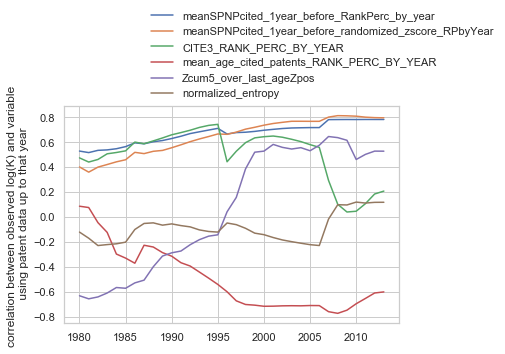

In [64]:
x = 'year'
#y = 'correlation_logK_predicted_logK'
y = 'correlation_logK_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
name_fig = 'Correlation_over_time'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

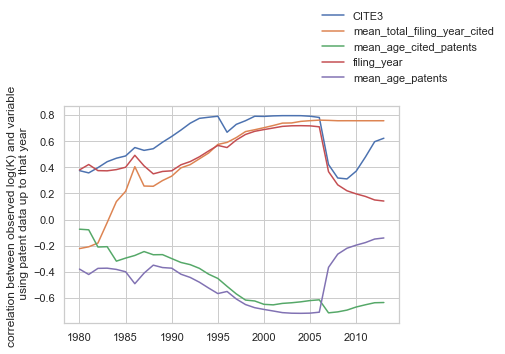

In [65]:
x = 'year'
#y = 'correlation_logK_predicted_logK'
y = 'correlation_logK_variable'

for i in (['CITE3',
           'mean_total_filing_year_cited',
           'mean_age_cited_patents',
           'filing_year',
           'mean_age_patents']):
    idx = DF_stability_prediction_over_time_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
name_fig = 'Correlation_over_time_B&M_variables'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

# Monte Carlo Cross-validation

In [68]:
num_iterations = 100

DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON = pd.DataFrame()

list_predictors = list(DF_domains_over_time.columns[5:])
list_predictors[len(list_predictors):len(list_predictors)] = ['number_patents_up_to_year']

x = 'predicted_log_K'
y = 'log_K'

for predictor in tqdm(list_predictors):
    DF_stability_prediction_over_time = pd.DataFrame()
    equation = y + ' ~ ' + predictor #'-1' # this removes the constant

    for year in range(1980,2014):
        correlation_variable_and_K = list()
        correlation_predicted_observed_K = list()
        intercept = list()
        coefficient_variable = list()
    
        for iteration in range(num_iterations):
            DATA = DF_domains_over_time[(DF_domains_over_time['year']==year) & (DF_domains_over_time['number_patents_up_to_year']>=100)]
            DATA_set1 = DATA.sample(frac=0.5, replace=False, weights=None, random_state=None)
            idx_out_of_sample = ~DATA['Domain'].isin(DATA_set1['Domain'])
            DATA_set2 = DATA[idx_out_of_sample]
            idx = (~isnan(DATA_set1[y])) & (~isnan(DATA_set1[predictor]))
            correlation_variable_and_K_set1 = pearsonr(DATA_set1[predictor][idx],DATA_set1[y][idx])[0]

            correlation_variable_and_K.append(correlation_variable_and_K_set1)

            # train on set1 and test on set2
            lm = smf.ols(formula=equation, data=DATA_set1).fit()    
            DATA_set2[x] = ((lm.params[0] + lm.params[1]*DATA_set2[predictor]))
            idx = (~isnan(DATA_set2[y])) & (~isnan(DATA_set2[x]))
            correlation_predicted_observed_K_set2 = pearsonr(DATA_set2[x][idx],DATA_set2[y][idx])[0]
            intercept.append(lm.params[0])
            coefficient_variable.append(lm.params[1])

            correlation_predicted_observed_K.append(correlation_predicted_observed_K_set2)
        
            
        DF = pd.DataFrame({ 'year': year,
                            'mean_correlation_logK_variable' : mean(correlation_variable_and_K),
                            'std_correlation_logK_variable' : std(correlation_variable_and_K),
                            'mean_correlation_logK_predicted_logK': mean(correlation_predicted_observed_K),
                            'std_correlation_logK_predicted_logK' : std(correlation_predicted_observed_K),
                            'mean_intercept': mean(intercept),
                            'std_intercept': std(intercept),
                            'mean_coefficient_variable': mean(coefficient_variable),
                            'std_coefficient_variable': std(coefficient_variable)},index = [year])
        DF_stability_prediction_over_time = DF_stability_prediction_over_time.append(DF)
    
    DF_stability_prediction_over_time['predictor'] = predictor
    DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON = (DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON
                                                            .append(DF_stability_prediction_over_time))

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [11:49<00:00, 30.84s/it]


## Export Monte Carlo Results

In [70]:
DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON.to_csv(export_path+'DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON.csv')

## Centrality after 3 years

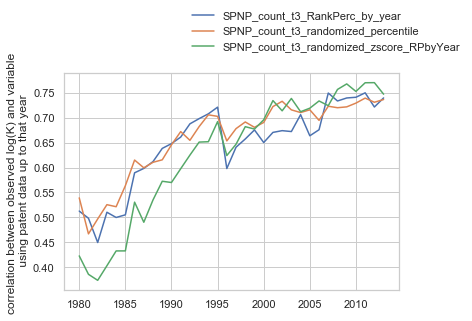

In [71]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in ['SPNP_count_t3_RankPerc_by_year','SPNP_count_t3_randomized_percentile','SPNP_count_t3_randomized_zscore_RPbyYear']:
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
name_fig = 'MonteCarlo_CrossValidation_' + 'centrality_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

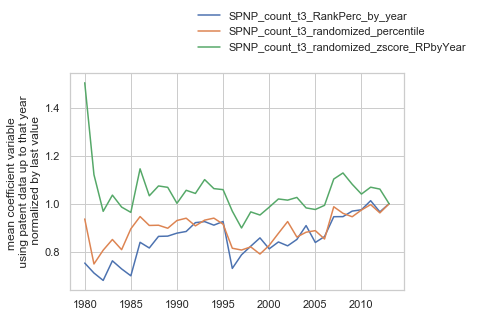

In [72]:
x = 'year'
y = 'mean_coefficient_variable'

for i in ['SPNP_count_t3_RankPerc_by_year','SPNP_count_t3_randomized_percentile','SPNP_count_t3_randomized_zscore_RPbyYear']:
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
name_fig = 'MonteCarlo_CrossValidation_' + 'centrality_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Centrality cited patents

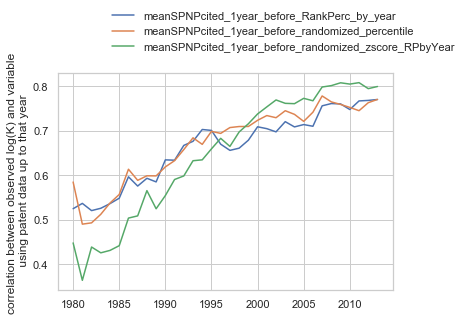

In [73]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_percentile',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
name_fig = 'MonteCarlo_CrossValidation_' + 'centrality_cited_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

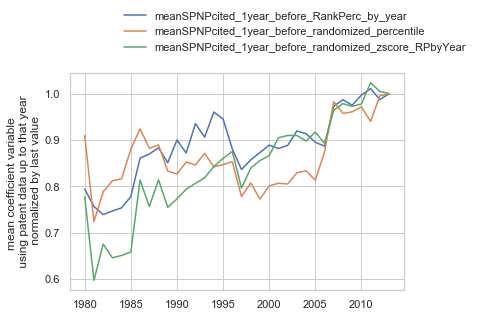

In [74]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_percentile',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
name_fig = 'MonteCarlo_CrossValidation_' + 'centrality_cited_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Mean age cited patents vs Obsolescence Index

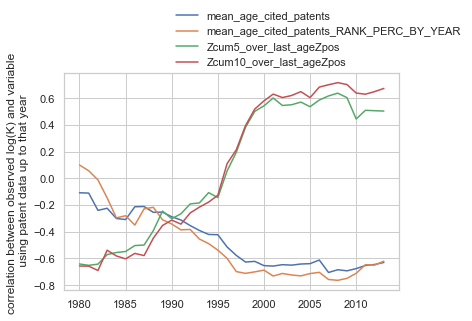

In [75]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['mean_age_cited_patents',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'Zcum10_over_last_ageZpos']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
name_fig = 'MonteCarlo_CrossValidation_' + 'obsolescence_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

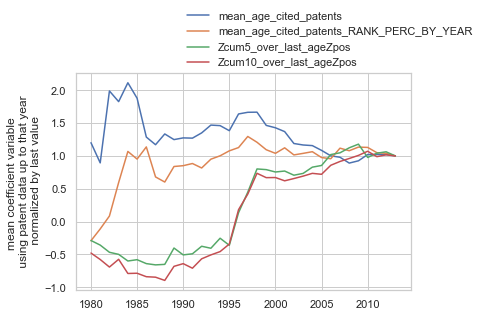

In [76]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['mean_age_cited_patents',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'Zcum10_over_last_ageZpos']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
name_fig = 'MonteCarlo_CrossValidation_' + 'obsolescence_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

# Cite3

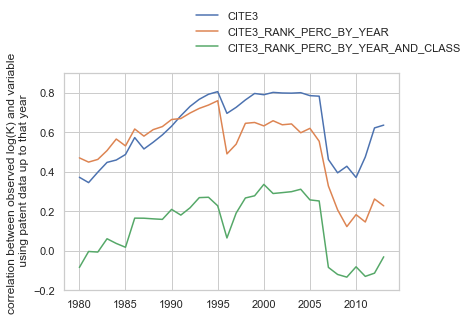

In [77]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['CITE3',
           'CITE3_RANK_PERC_BY_YEAR',
           'CITE3_RANK_PERC_BY_YEAR_AND_CLASS']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
ylim(-0.2,0.9)
name_fig = 'MonteCarlo_CrossValidation_' + 'CITE3_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

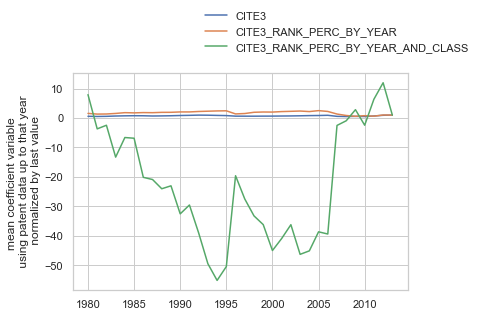

In [78]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['CITE3',
           'CITE3_RANK_PERC_BY_YEAR',
           'CITE3_RANK_PERC_BY_YEAR_AND_CLASS']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-6)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
name_fig = 'MonteCarlo_CrossValidation_' + 'CITE3_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Figure 3 A

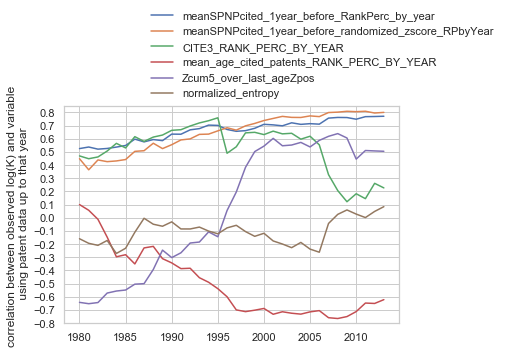

In [81]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
plt.yticks(array(range(-8,11))/10)
ylim(-0.8,0.85)
name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Figure 3 B

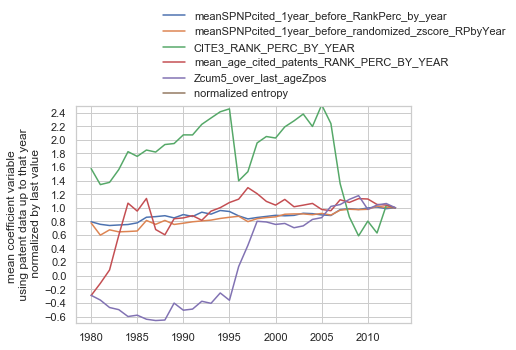

In [82]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
ylim(-0.7,2.5)
list_yticks = array(range(-7,25))/10 
list_yticks = list_yticks[1::2] #take only odd numbers. To take only even numbers use [::2]
plt.yticks(list_yticks)
name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

### INSET

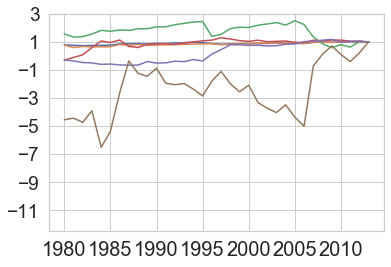

In [83]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

#legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
#ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
ylim(-12.5,3)
list_yticks = array(range(-12,4)) 
list_yticks = list_yticks[1::2] #take only odd numbers. To take only even numbers use [::2]
yticks(list_yticks)
xticks(fontsize=20)#, rotation=90)
yticks(fontsize=19)#, rotation=90)
name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_coefficient_inset'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

# Figure 3 C

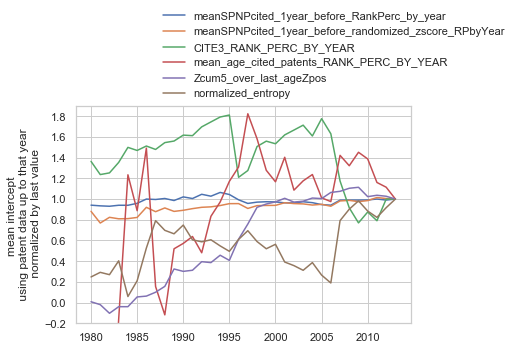

In [84]:
x = 'year'
y = 'mean_intercept'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
ylabel('mean intercept \n using patent data up to that year \n normalized by last value')
ylim(-0.2,1.9)
list_yticks = array(range(-2,19))/10 
list_yticks = list_yticks[::2] #take only even numbers. To take only odd numbers use [1::2]
plt.yticks(list_yticks)
name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_intercept'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

### INSET

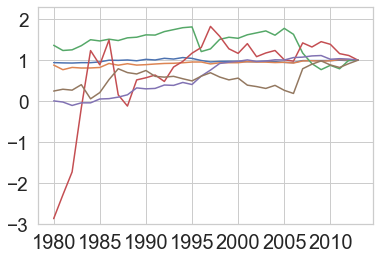

In [85]:
x = 'year'
y = 'mean_intercept'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

#legend(loc='upper right',frameon=False,  borderaxespad=-9)
#xlabel('filing year')
#ylabel('mean intercept \n using patent data up to that year \n normalized by last value')
ylim(-3,2.3)
xticks(fontsize=20)#, rotation=90)
yticks(fontsize=19)#, rotation=90)
name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_intercept_inset'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Complete Figure 3

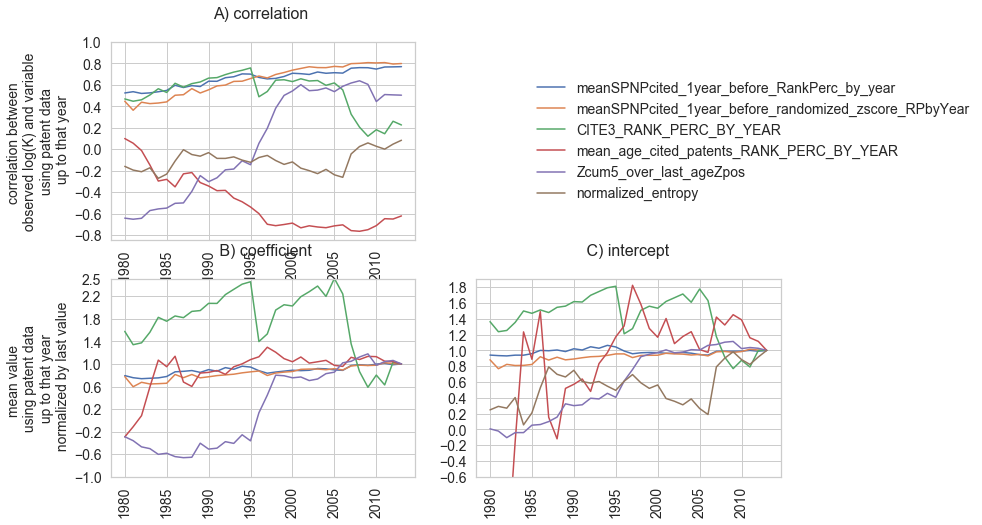

In [87]:
f, ax = subplots(figsize=(12, 8))

subplot(2,2,1)
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))

legend(loc='center right',frameon=False,  borderaxespad=-40, fontsize=14)
title('A) correlation \n',fontsize=16)
ylabel('correlation between \n observed log(K) and variable \n using patent data \n up to that year',fontsize=14)
list_yticks = linspace(-0.8,1,10)
yticks(list_yticks)
xticks(rotation=90,fontsize=14)
yticks(fontsize=14)

#subplot(2,2,2)

subplot(2,2,3)
x = 'year'
y = 'mean_coefficient_variable'

for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

title('\n B) coefficient\n',fontsize=16)
ylabel('mean value \n using patent data \n up to that year \n normalized by last value',fontsize=14)
ylim(-1,2.5)
#list_yticks = array(range(-7,25))/10 
#list_yticks = list_yticks[1::2] #take only odd numbers. To take only even numbers use [::2]
yticks([-1, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8, 2.2, 2.5])
xticks(rotation=90,fontsize=14)
yticks(fontsize=14)

subplot(2,2,4)
x = 'year'
y = 'mean_intercept'
for i in (['meanSPNPcited_1year_before_RankPerc_by_year',
           'meanSPNPcited_1year_before_randomized_zscore_RPbyYear',
           'CITE3_RANK_PERC_BY_YEAR',
           'mean_age_cited_patents_RANK_PERC_BY_YEAR',
           'Zcum5_over_last_ageZpos',
           'normalized_entropy']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))
    
title('\n C) intercept \n', fontsize=16)
#ylabel('mean intercept \n using patent data up to that year \n normalized by last value')
ylim(-0.6,1.9)
list_yticks = array(range(-6,19))/10 
list_yticks = list_yticks[::2] #take only even numbers. To take only odd numbers use [1::2]
yticks(list_yticks)
xticks(rotation=90,fontsize=14)
yticks(fontsize=14)

name_fig = 'MonteCarlo_CrossValidation_' + 'Fig7_3PANELS'
format_fig = '.svg'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=60)
#format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

## Figure S6 for Supplemental Information

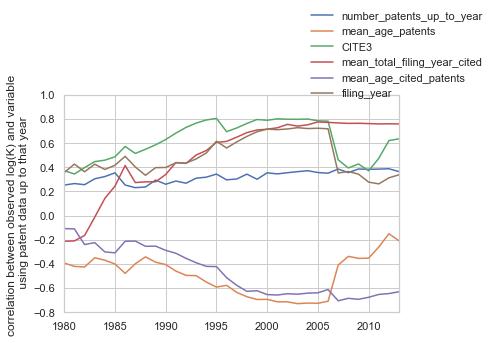

In [91]:
x = 'year'
y = 'mean_correlation_logK_variable'

for i in (['number_patents_up_to_year',
           'mean_age_patents',
           'CITE3',
           'mean_total_filing_year_cited',
           'mean_age_cited_patents',
           'filing_year']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx], 
          label= i))
ylim(-0.8,1)
legend(loc='upper right',frameon=False,  borderaxespad=-8)
#xlabel('filing year')
ylabel('correlation between observed log(K) and variable \n using patent data up to that year')
xlim(1980,2013)
name_fig = 'MonteCarlo_CrossValidation_' + 'CB&CM_variables_correlation'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

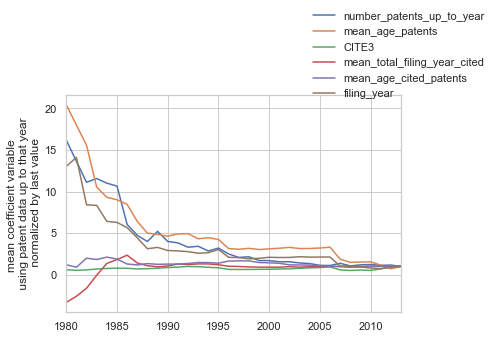

In [90]:
x = 'year'
y = 'mean_coefficient_variable'

for i in (['number_patents_up_to_year',
           'mean_age_patents',
           'CITE3',
           'mean_total_filing_year_cited',
           'mean_age_cited_patents',
           'filing_year']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-8)
#xlabel('filing year')
ylabel('mean coefficient variable \n using patent data up to that year \n normalized by last value')
xlim(1980,2013)
name_fig = 'MonteCarlo_CrossValidation_' + 'CB&CM_variables_coefficient'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)

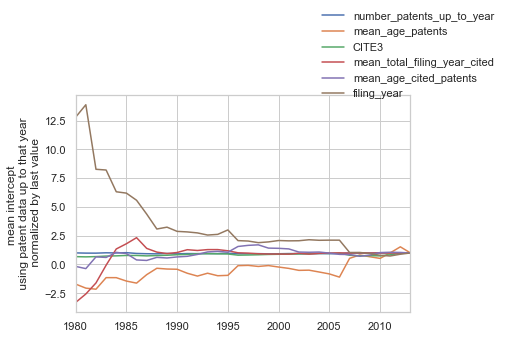

In [92]:
x = 'year'
y = 'mean_intercept'

for i in (['number_patents_up_to_year',
           'mean_age_patents',
           'CITE3',
           'mean_total_filing_year_cited',
           'mean_age_cited_patents',
           'filing_year']):
    idx = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON['predictor']==i
    last_coeff = DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx][-1:]
    (plot(DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[x][idx], 
          DF_stability_prediction_over_time_MONTE_CARLO_COMPARISON[y][idx]/array(last_coeff), 
          label= i))

legend(loc='upper right',frameon=False,  borderaxespad=-8)
#xlabel('filing year')
ylabel('mean intercept \n using patent data up to that year \n normalized by last value')
xlim(1980,2013)
name_fig = 'MonteCarlo_CrossValidation_' + 'CB&CM_variables_intercept'
format_fig = '.tiff'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.pdf'
savefig(path_fig+name_fig+format_fig, bbox_inches='tight', dpi=300)